We support Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes etc
We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
max_seq_length can be set to anything, since we do automatic RoPE Scaling via kaiokendev's method.
With PR 26037, we support downloading 4bit models 4x faster! Our repo has Llama, Mistral 4bit models.
[NEW] We make Phi-3 Medium / Mini 2x faster! See our Phi-3 Medium notebook

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2024-07-15 11:07:50.780419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA RTX A4000. Max memory: 15.731 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [3]:
# from unsloth import to_sharegpt
# import pandas as pd
# from datasets import Dataset
# with open("fineTuningData.txt", "r", encoding="utf-8", errors="ignore") as fin:
#     lines = fin.readlines()
# temp = ""
# for line in lines :
#     temp = temp + line
# blocks = temp.strip().split('@')

# # List to store the extracted data
# data = []

# # Parse each block
# for block in blocks:
#     if block.strip():  # Skip any empty blocks
#         lines = block.strip().split('\n')
#         type_ = lines[0].split('-')[1].strip()
#         status = lines[1].strip().replace('[','').replace(']','').replace("'","").replace("'","")
#         fact_line = lines[2].strip()
#         description_line =lines[4].strip() 
#         input = "The fact is : ["+fact_line+"] and the description is ["+description_line+"]"
#         data.append({
#             'Type': type_,
#             'output': status,
#             'input': input,
#         })

# # Create a DataFrame
# df = pd.DataFrame(data)
# dataset = Dataset.from_pandas(df)
# chat_template = """You are an expert at identifying if a given fact is correctly mentionned in a description.
# You answer shortly by saying correct if it is correctly mentionned or wrong if it isn't mentionned or wrongly mentionned.
# You ignore every other informations in the description. 

# ### Instruction:
# {INPUT}

# ### Response:
# {OUTPUT}

# ### Instruction:
# {INPUT}

# ### Response:
# {OUTPUT}
# """
# EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
# def formatting_prompts_func(examples):
#     inputs       = examples["input"]
#     outputs      = examples["output"]
#     texts = []
#     for input, output in zip(inputs, outputs):
#         # Must add EOS_TOKEN, otherwise your generation will go on forever!
#         text = chat_template.format(INPUT = input, OUTPUT = output) + EOS_TOKEN
#         texts.append(text)
#     return { "text" : texts, }
# pass

# dataset = dataset.map(formatting_prompts_func, batched = True,)
# print(df)



In [4]:
from unsloth import to_sharegpt
import pandas as pd
from datasets import Dataset
with open("fineTuningData2.txt", "r", encoding="utf-8", errors="ignore") as fin:
    lines = fin.readlines()
temp = ""
for line in lines :
    temp = temp + line
blocks = temp.strip().split('@')

# List to store the extracted data
data = []

# Parse each block
for block in blocks:
    if block.strip():  # Skip any empty blocks
        lines = block.strip().split('\n')
        type_ = lines[0].split('-')[1].strip()
        status = lines[1].strip().replace('[','').replace(']','').replace("'","").replace("'","")
        fact_line = lines[2].strip()
        description_line =lines[4].strip() 
        input = "The fact is : ["+fact_line+"] and the description is ["+description_line+"]"
        data.append({
            'Type': type_,
            'output': status,
            'input': input,
            'fact' : fact_line,
            'description':description_line
        })

# Create a DataFrame
df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)

dataset = to_sharegpt(
    dataset,
    merged_prompt = "The fact is : [{fact}] and the description is [{description}]",
    output_column_name = "output",
)
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(dataset)

chat_template_llama3 = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:\n{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

### Response:\n{OUTPUT}<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:\n{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

### Response:\n{OUTPUT}<|eot_id|>"""
chat_template1 = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:\n{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

### Response:\n{OUTPUT}<|eot_id|><|start_header_id|>user<|end_header_id|>

### Instruction:\n{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

### Response:\n{OUTPUT}<|eot_id|>"""
chat_template_gemma ="""{SYSTEM}

### Instruction:
{INPUT}

### Response:
{OUTPUT}

### Instruction:
{INPUT}

### Response:
{OUTPUT}
"""
system_message = "You are an expert at identifying if a given fact is correctly mentionned in a description. You answer shortly by saying correct if it is correctly mentionned or wrong if it is not mentionned or wrongly mentionned. You ignore every other informations in the description."


from unsloth import apply_chat_template
dataset = apply_chat_template(
    dataset,
    tokenizer = tokenizer,
    chat_template = chat_template_llama3,
    default_system_message = system_message ,
)

from datasets import load_dataset

train_test_split = dataset.train_test_split(test_size=0.2)  # 20% for evaluation
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']
print(len(train_dataset))

Merging columns:   0%|          | 0/11539 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/11539 [00:00<?, ? examples/s]

Standardizing format:   0%|          | 0/11539 [00:00<?, ? examples/s]

Map:   0%|          | 0/11539 [00:00<?, ? examples/s]

9231


Train the model

In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        num_train_epochs = 2,
        warmup_steps = 5,
       # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/9231 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2308 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Show current memory stats

In [6]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX A4000. Max memory = 15.731 GB.
5.594 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,231 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 2,308
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.900800
2,3.004800
3,3.057100
4,2.626000
5,2.564700
6,2.308400
7,1.904900
8,1.840000
9,1.671300
10,1.489900


Show final memory and time stats

In [1]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'torch' is not defined

Ollama Support

In [2]:
#model.save_pretrained_gguf("model", tokenizer,)
#model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
#model.save_pretrained_gguf("model", tokenizer, quantization_method = "q5_k_m")
#model.save_pretrained_gguf("model", tokenizer, quantization_method = "quantized")

NameError: name 'model' is not defined

In [ ]:
print(tokenizer._ollama_modelfile)

In [1]:
%matplotlib inline
from Graphs.resultAnalysis import main


main()

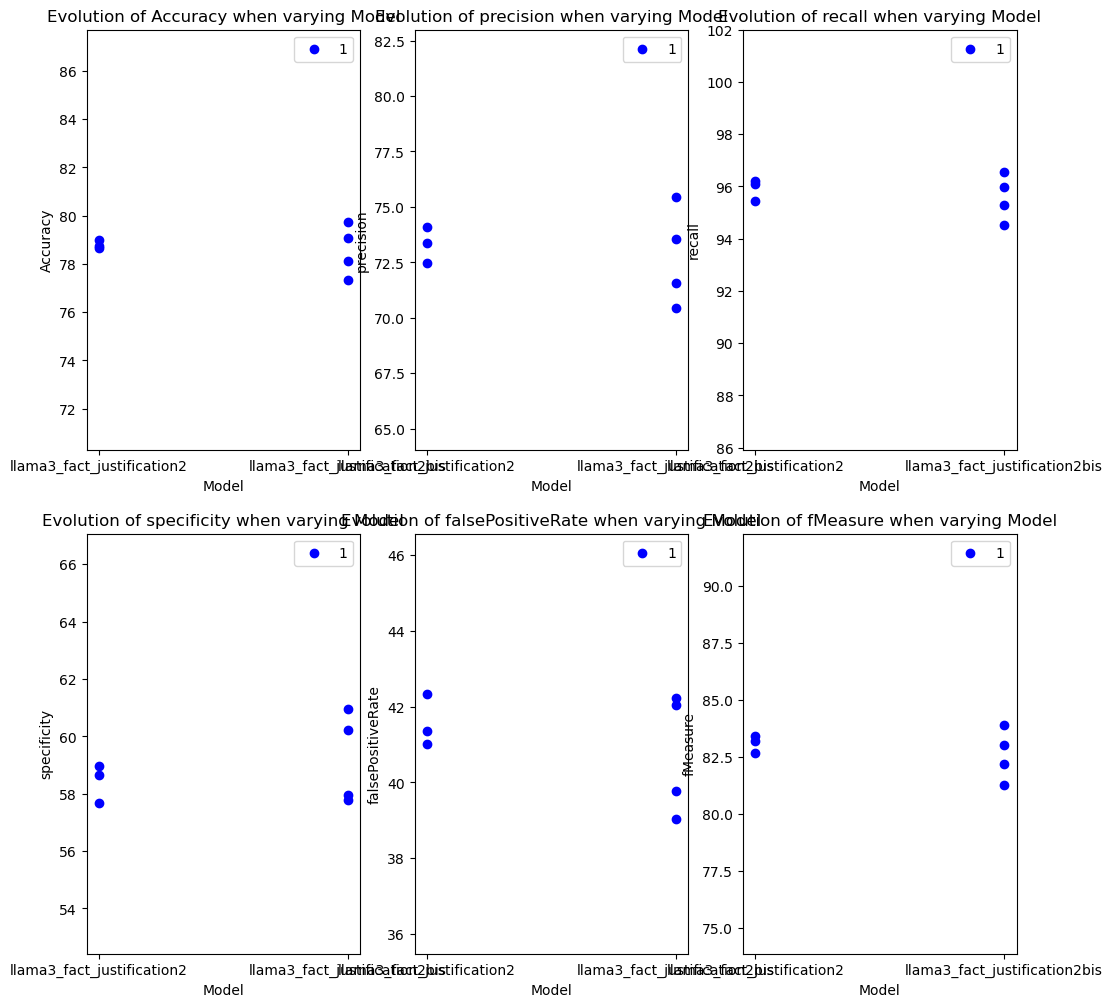

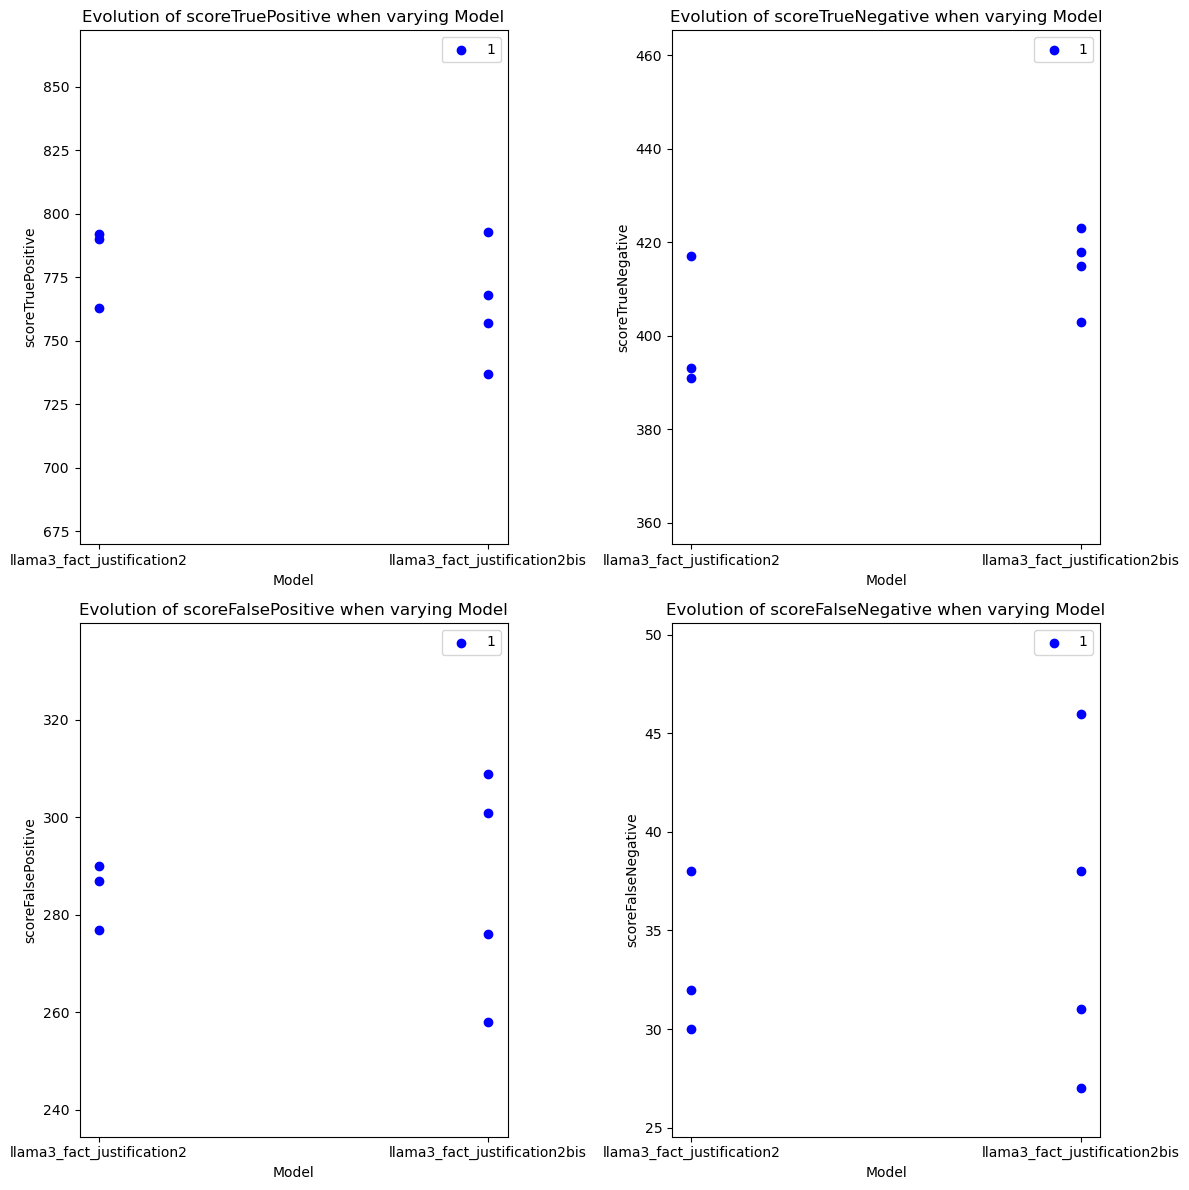

In [1]:
%matplotlib inline
from Graphs.resultAnalysis import main


main()